In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)

In [16]:
#-----------------------------------------------Stubs------------------------------------------------
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel


#-----------------------------------------------BMTF------------------------------------------------
nBmtf = bmtf_gmt.nBmtfMuons
BmtfPhi = bmtf_gmt.bmtfPhi
BmtfEta = bmtf_gmt.bmtfEta
BmtfPt = bmtf_gmt.bmtfPt
BmtfQual = bmtf_gmt.bmtfHwQual
bmtfProc = bmtf_gmt.bmtfProcessor

#-----------------------------------------------GMT------------------------------------------------
nGmt = bmtf_gmt.nGmtMuons


In [15]:
for i in range(1000):
  if nStubs[i] > 4:
    print(i, nStubs[i], stubsStation[i], stubsSector[i], stubsWheel[i])
    print(i, nBmtf[i], bmtfProc[i])

71 6 [3, 4, 3, 2, 1, 2] [1, 1, 1, 1, 1, 7] [-1, -1, -1, -1, -1, -2]
71 1 [1]
172 5 [3, 2, 1, 4, 1] [1, 1, 1, 1, 8] [-1, -1, -1, -1, -1]
172 1 [1]
280 5 [1, 3, 2, 1, 4] [0, 0, 0, 0, 1] [1, 2, 1, 1, 2]
280 2 [0, 1]
530 6 [4, 3, 1, 1, 2, 4] [2, 2, 2, 2, 2, 2] [-1, -1, 0, -1, -1, 1]
530 2 [2, 2]
582 5 [3, 4, 2, 2, 1] [11, 11, 11, 11, 11] [1, 1, 1, 1, 1]
582 1 [11]
596 5 [1, 4, 3, 2, 1] [9, 9, 9, 9, 9] [-1, -2, -2, -2, -1]
596 1 [9]
705 5 [2, 2, 3, 1, 4] [7, 11, 11, 11, 11] [-2, 1, 1, 1, 1]
705 1 [11]
737 7 [4, 3, 1, 1, 2, 2, 3] [2, 2, 2, 2, 2, 7, 7] [1, 1, 1, 1, 1, -2, -2]
737 2 [2, 7]
801 6 [4, 3, 3, 2, 3, 4] [6, 7, 7, 7, 7, 7] [1, 2, 1, 2, 2, 1]
801 3 [6, 7, 7]
997 5 [4, 2, 4, 2, 4] [3, 4, 5, 6, 6] [-2, -1, 2, 1, 2]
997 3 [3, 5, 6]


In [30]:
BmtfFeatures = [nBmtf, BmtfPhi, BmtfEta, BmtfPt, BmtfQual]



array([], dtype=float32)

In [62]:
def DeltaR(Phi1, Phi2, Eta1, Eta2):
  return np.sqrt((Phi1 - Phi2)**2 + (Eta1 - Eta2)**2)

In [84]:
Number = 1_000_000
MuonsEvents = []


for i in tqdm.tqdm(range(Number)):

  #Fare in questo modo ottimizza enormemente il processo!
  nMuons = BmtfFeatures[0][i]
  ArrPhi, ArrEta = np.array(BmtfFeatures[1][i]), np.array(BmtfFeatures[2][i])

  ArrPt = np.array(BmtfFeatures[3][i])
  ArrQual = np.array(BmtfFeatures[4][i])


  DeltaRList = []
  IndexMin = []

  Pt, Eta, Phi, Qual = [], [], [], []
  PtP1, EtaP1, PhiP1, QualP1 = [], [], [], []

  ArrDeltaPhi, ArrDeltaEta = [], []
  Index = []

  ithMuon = []
  iP1thMuon = []


  #Controllo globale dei match 
  if nMuons == 0:
    unmatched = []
  
  else:

    if BmtfFeatures[0][i + 1] == 0:
      unmatched = []

    else:
      for j in range(nMuons):
        DeltaRTemp = DeltaR(ArrPhi[j], BmtfFeatures[1][i + 1][:], ArrEta[j], BmtfFeatures[2][i + 1][:])

        minDeltaR = np.min(DeltaRTemp)
        IndexP1 = np.argmin(DeltaRTemp)
        DeltaRList.append(minDeltaR)
        Index.append((j, IndexP1))



    
  MuonProperty = {}
  MuonP1Property = {}
    
  for feature in ['Pt', 'Eta', 'Phi', 'Qual']:
    MuonProperty[feature] = []
  for feature in ['PtP1', 'EtaP1', 'PhiP1', 'QualP1']: 
    MuonP1Property[feature] = []

  for indx, (j, IndexP1) in enumerate(Index):
      MuonProperty['Pt'].append(ArrPt[j])
      MuonProperty['Eta'].append(ArrEta[j])
      MuonProperty['Phi'].append(ArrPhi[j])
      MuonProperty['Qual'].append(ArrQual[j])

      MuonP1Property['PtP1'].append(BmtfFeatures[3][i + 1][IndexP1])
      MuonP1Property['EtaP1'].append(BmtfFeatures[2][i + 1][IndexP1])
      MuonP1Property['PhiP1'].append(BmtfFeatures[1][i + 1][IndexP1])
      MuonP1Property['QualP1'].append(BmtfFeatures[4][i + 1][IndexP1])
      

  #Salvataggio nel dizionario
  Events = {
    'Unmatched': unmatched,
    'DeltaR': DeltaRList,
    'MuonProperty': MuonProperty,\
    'MuonP1Property': MuonP1Property

  }

  MuonsEvents.append(Events)


100%|██████████| 1000000/1000000 [05:06<00:00, 3264.82it/s]


In [85]:
MuonsEvents = ak.Array(MuonsEvents)

In [86]:
MuonsEvents

<Array [{Unmatched: [], DeltaR: [], ...}, ...] type='1000000 * {Unmatched: ...'>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


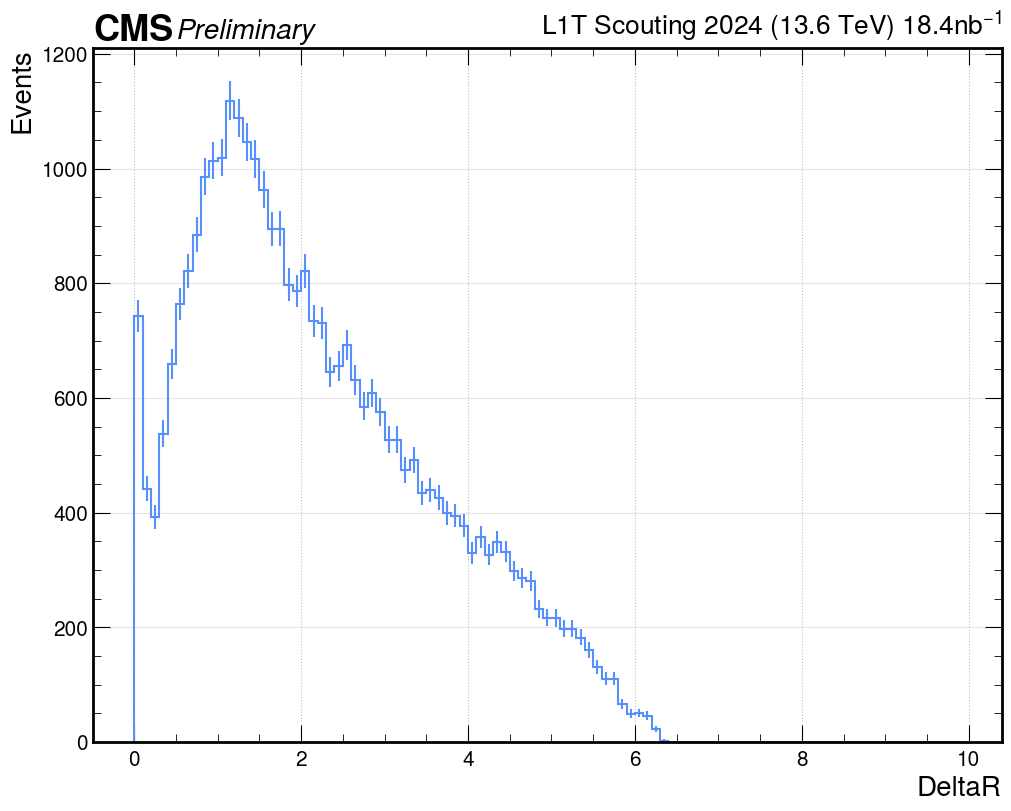

In [87]:
bins = np.arange(0, 10, 0.1)
DeltaRDist_Hist = hist.Hist(hist.axis.Variable(bins, name="DeltaR", label="DeltaR"))

DeltaRDist_Hist.fill(DeltaR = ak.flatten(MuonsEvents.DeltaR))

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(DeltaRDist_Hist)

ax.grid(True)
ax.legend(fontsize = FONTSIZE)
ax.set_ylabel("Events")

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.show()
